In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import copy
from scipy.signal import find_peaks, resample
from icecream import ic
from collections import OrderedDict

from neurolib.models.aln import ALNModel
from neurolib.models.aln import ALNModel_SaveSteps
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func  
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import os
import sys
from pynverse import inversefunc

from intersect import intersection


sys.path.insert(0, '..')
from prc_funcs import *
from functions import *
    

import matplotlib.colors as mcolors

colors = mcolors.TABLEAU_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
colrs = [name for hsv, name in by_hsv]

#hide
import logging
logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

BASE_PATH = "../../../../" # need to go back from default hdf path "./data/hdf"
HDF_PATH = BASE_PATH + "Data/"

# Pic of stimulus and measurement of rapid decay

In [2]:
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.1
aln.params['sampling_dt'] = aln.params.dt
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
prc = PRC_ALN_testing(aln)

INFO:root:aln: Model initialized.


initialised ...


Text(0.5, 0, 't [ms]')

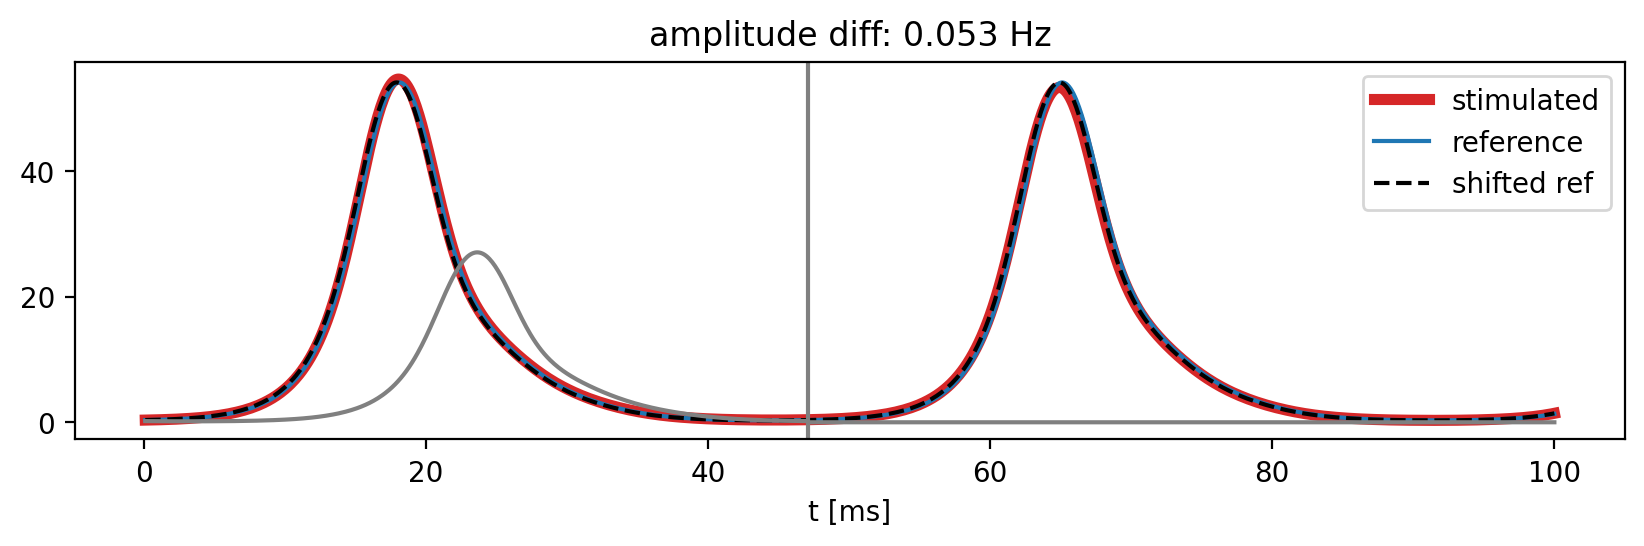

In [3]:
'''
Test the applicability of PRC as in "rapid decay"
'''

Ke_gl = 20
itype = "real"
stim_type = "step"
amplitude = 0.4
stim_len = 5
delay = 0


# run model to store state vector of a point inside LC
aln.params.duration = 6000
aln.run(continue_run=True)

# create reference deepcopy without stimulation
aln_ref = copy.deepcopy(aln)
aln_ref.params.duration = 10000
aln_ref.run()

# find peaks in reference run to determine stimulus phase
peaks, props = find_peaks(aln_ref.rates_exc[0].T, height = -20)
f_peak_ref = peaks[0] * aln_ref.params.dt
s_peak_ref = peaks[1] * aln_ref.params.dt
t_peak_ref = peaks[2] * aln_ref.params.dt
#ic(f_peak_ref, s_peak_ref, t_peak_ref)

aln_s = copy.deepcopy(aln)
aln_s.params.duration = 10000
aln_s.params.Ke_gl = Ke_gl # regardless of current/rate input

if itype in ["current", "rate"]:
    if stim_type=="sine":
        stimulus = ShiftedSinusoidalInput(
            amplitude=amplitude,
            frequency=1000 / prc.frperiod,
            peak_at=delay,
            start=0,
            end=prc.frperiod,
        ).as_array(aln_s.params.duration, aln_s.params.dt)

        delay = 0 #because of the plotting
    else:
        stimulus = stim.StepInput(
            step_size = amplitude, 
            start = delay, 
            end = delay+stim_len,
            n = 1
        ).as_array(aln_s.params.duration, aln_s.params.dt)

    if itype == "current":
        aln_s.params["ext_exc_current"] = stimulus
    elif itype == "rate":
        aln_s.params["ext_exc_rate"] = stimulus * 1e-3 # convert Hz to kHz

elif itype == "real":

    stimulus = ALNRatesStimulus(
        start = delay,
        #start = int(0.5*self.frperiod) + delay,
        rates = prc.frcycle, 
        frperiod = prc.frperiod
    ).as_array(aln_s.params.duration, aln_s.params.dt)

    aln_s.params["ext_exc_rate"] = stimulus * 1e-3 # convert Hz to kHz
else: 
    print("input must be 'current', 'rate', or 'real'")

aln_s.run(continue_run=True)

# determine phase of stimulus input
if itype == "real":
    stim_len = prc.frperiod 

input_peak = delay + stim_len / 2

if input_peak < f_peak_ref:
    phase_t = prc.frperiod - (f_peak_ref - input_peak) # period - time to period end
elif input_peak < s_peak_ref:
    phase_t = prc.frperiod - (s_peak_ref - input_peak)
elif input_peak < t_peak_ref:
    phase_t = prc.frperiod - (t_peak_ref - input_peak)
else: 
    print("ERROR: stimulus delay > freerunning period")
    ic(delay, prc.frperiod)

# find peaks in stimulated runs and compare to freerunning reference
peaks, props = find_peaks(aln.rates_exc[0].T, prominence=3)
f_peak = peaks[0] * aln_s.params.dt  # in ms
s_peak = peaks[1] * aln_s.params.dt
t_peak = peaks[2] * aln_s.params.dt

# find phase shift to reference run by crosscorrelation 
# phase_shift in [-1, 1]

p_shift, dt_shift = phase_shift(aln_ref.rates_exc[0],
                          aln_s.rates_exc[0],
                          duration=6000, 
                          dt=aln.params.dt)
#ic(p_shift)
# evaluation point: 
eval_point = int((prc.frperiod + delay) / aln_s.params.dt)
#ic(self.frperiod + delay)
#ic(eval_point)
# calculate amplitude difference of stimulated and shifted reference run
ref_shifted = shift(aln_ref.rates_exc[0], int(dt_shift), cval=0)

amp_diff = aln_s.rates_exc[0][eval_point] - ref_shifted[eval_point]
#ic(aln.rates_exc[0][eval_point], ref_shifted[eval_point])
#ic(ref_shifted[eval_point])

fig, ax = plt.subplots(figsize=(10, 2.5), dpi=200)
ax.set_title("amplitude diff: {0:.3f} Hz".format(amp_diff))
ax.plot(aln_s.t[0:int(100/aln_s.params.dt)],
            aln_s.rates_exc[0].T[0:int(100/aln_s.params.dt)], lw=4, c="tab:red", label="stimulated")
ax.plot(aln_s.t[0:int(100/aln_s.params.dt)],
            aln_ref.rates_exc[0].T[0:int(100/aln_s.params.dt)], c="tab:blue", label="reference")
ax.plot(aln_s.t[0:int(100/aln_s.params.dt)],
            ref_shifted.T[0:int(100/aln_s.params.dt)], "--", color="black", label="shifted ref")
#ax.axvline(delay, color="grey")
#axs[0].axvspan(delay, delay+stim_len, facecolor='grey', alpha=0.4, label="stimulus")
ax.axvline(prc.frperiod + delay, color="grey")
#ax.axvspan(prc.frperiod + delay, prc.frperiod + delay+stim_len, facecolor='grey', alpha=0.4)
#ic(len(aln.t), len(stimulus))
ax.plot(aln_s.t[0:int(100/aln_s.params.dt)],
            stimulus[0][0:int(100/aln_s.params.dt)]/2, c="grey")

#ax.set_xlim(1500, 2500)
ax.legend()
ax.set_xlabel("t [ms]")
#self.amp_diffs[delay] = amp_diff


## now with my style

ic| input_peak-f_peak_ref: 11.629411764705882
ic| lab: [0.0, 10.0, 20.0, 30.0, 40.0, 50.0]


Text(184.06944444444443, 0.5, 'Activity [Hz]')

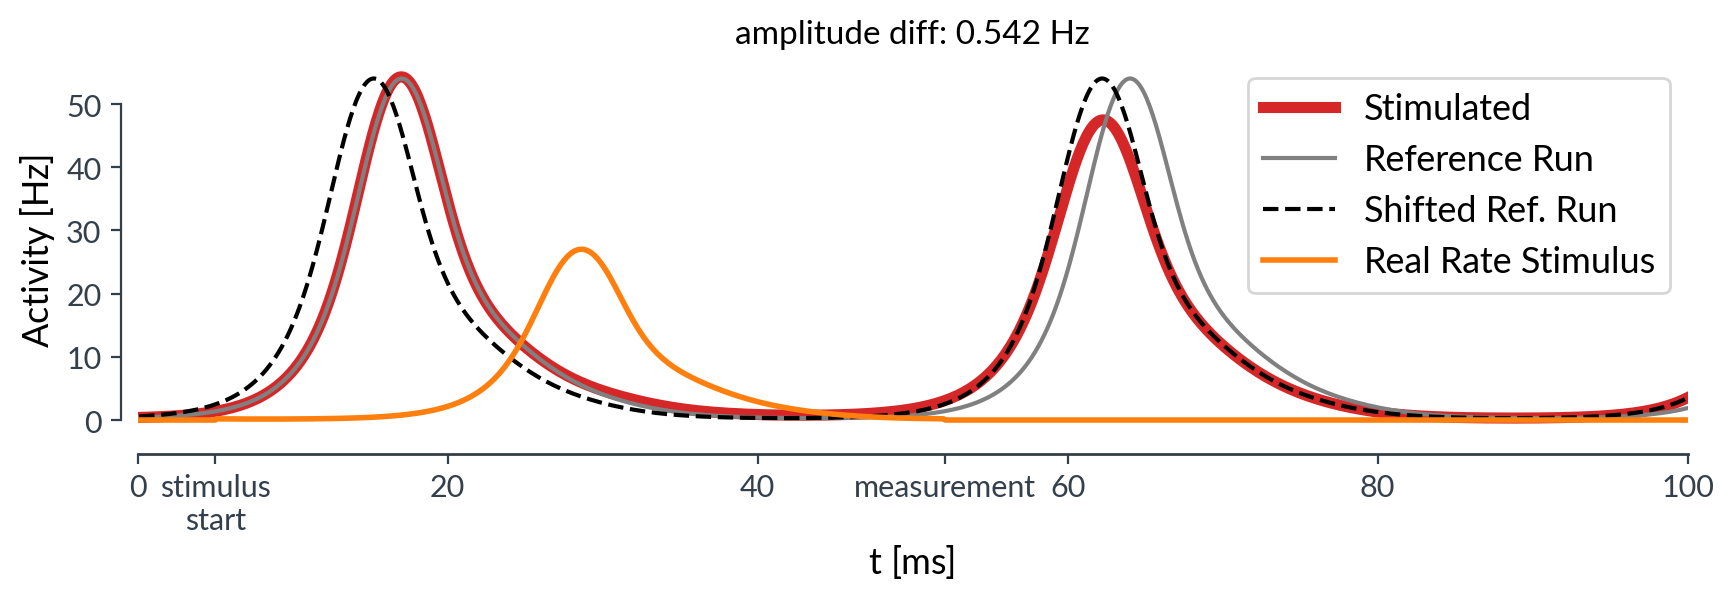

In [6]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

'''
Test the applicability of PRC as in "rapid decay"
'''

Ke_gl = 40
itype = "real"
stim_type = "step"
amplitude = 0.4
stim_len = 5
delay = 5


# run model to store state vector of a point inside LC
aln.params.duration = 6000
aln.run(continue_run=True)

# create reference deepcopy without stimulation
aln_ref = copy.deepcopy(aln)
aln_ref.params.duration = 10000
aln_ref.run()

# find peaks in reference run to determine stimulus phase
peaks, props = find_peaks(aln_ref.rates_exc[0].T, height = -20)
f_peak_ref = peaks[0] * aln_ref.params.dt
s_peak_ref = peaks[1] * aln_ref.params.dt
t_peak_ref = peaks[2] * aln_ref.params.dt
#ic(f_peak_ref, s_peak_ref, t_peak_ref)

aln_s = copy.deepcopy(aln)
aln_s.params.duration = 10000
aln_s.params.Ke_gl = Ke_gl # regardless of current/rate input

if itype in ["current", "rate"]:
    if stim_type=="sine":
        stimulus = ShiftedSinusoidalInput(
            amplitude=amplitude,
            frequency=1000 / prc.frperiod,
            peak_at=delay,
            start=0,
            end=prc.frperiod,
        ).as_array(aln_s.params.duration, aln_s.params.dt)

        delay = 0 #because of the plotting
    else:
        stimulus = stim.StepInput(
            step_size = amplitude, 
            start = delay, 
            end = delay+stim_len,
            n = 1
        ).as_array(aln_s.params.duration, aln_s.params.dt)

    if itype == "current":
        aln_s.params["ext_exc_current"] = stimulus
    elif itype == "rate":
        aln_s.params["ext_exc_rate"] = stimulus * 1e-3 # convert Hz to kHz

elif itype == "real":

    stimulus = ALNRatesStimulus(
        start = delay,
        #start = int(0.5*self.frperiod) + delay,
        rates = prc.frcycle, 
        frperiod = prc.frperiod
    ).as_array(aln_s.params.duration, aln_s.params.dt)

    aln_s.params["ext_exc_rate"] = stimulus * 1e-3 # convert Hz to kHz
else: 
    print("input must be 'current', 'rate', or 'real'")

aln_s.run(continue_run=True)

# determine phase of stimulus input
if itype == "real":
    stim_len = prc.frperiod 

input_peak = delay + stim_len / 2

if input_peak < f_peak_ref:
    phase_t = prc.frperiod - (f_peak_ref - input_peak) # period - time to period end
elif input_peak < s_peak_ref:
    phase_t = prc.frperiod - (s_peak_ref - input_peak)
elif input_peak < t_peak_ref:
    phase_t = prc.frperiod - (t_peak_ref - input_peak)
else: 
    print("ERROR: stimulus delay > freerunning period")
    ic(delay, prc.frperiod)

# find peaks in stimulated runs and compare to freerunning reference
peaks, props = find_peaks(aln.rates_exc[0].T, prominence=3)
f_peak = peaks[0] * aln_s.params.dt  # in ms
s_peak = peaks[1] * aln_s.params.dt
t_peak = peaks[2] * aln_s.params.dt

# find phase shift to reference run by crosscorrelation 
# phase_shift in [-1, 1]

p_shift, dt_shift = phase_shift(aln_ref.rates_exc[0],
                          aln_s.rates_exc[0],
                          duration=6000, 
                          dt=aln.params.dt)
#ic(p_shift)
# evaluation point: 
eval_point = int((prc.frperiod + delay) / aln_s.params.dt)
#ic(self.frperiod + delay)
#ic(eval_point)
# calculate amplitude difference of stimulated and shifted reference run
ref_shifted = shift(aln_ref.rates_exc[0], int(dt_shift), cval=0)

amp_diff = aln_s.rates_exc[0][eval_point] - ref_shifted[eval_point]
#ic(aln.rates_exc[0][eval_point], ref_shifted[eval_point])
#ic(ref_shifted[eval_point])

fig, ax = plt.subplots(figsize=(10, 2.5), dpi=200)
ax.set_title("amplitude diff: {0:.3f} Hz".format(amp_diff))
ax.plot(aln_s.t, aln_s.rates_exc[0].T, lw=4, c="tab:red", label="Stimulated")
ax.plot(aln_s.t, aln_ref.rates_exc[0].T, c="grey", label="Reference Run")
ax.plot(aln_s.t, ref_shifted.T, "--", color="black", label="Shifted Ref. Run")
#ax.axvline(delay, color="grey")
#axs[0].axvspan(delay, delay+stim_len, facecolor='grey', alpha=0.4, label="stimulus")
#ax.axvline(prc.frperiod + delay, color="grey")
#ax.axvspan(prc.frperiod + delay, prc.frperiod + delay+stim_len, facecolor='grey', alpha=0.4)
#ic(len(aln.t), len(stimulus))
ax.plot(aln_s.t, stimulus[0]/2, c="tab:orange", lw=2, label="Real Rate Stimulus")

ax.set_xlim(0,100)

ax.set_xticks([0, delay, 20, 40, delay + prc.frperiod, 60, 80, 100])
ic(input_peak-f_peak_ref)
ax.set_xticklabels(labels=['0','stimulus\nstart', '20', '40', 'measurement', '60', '80', '100'] )
#axs[1].set_ylim(-1, 65)
#axs[1].legend(loc="upper right")

ax.tick_params(right=False, top=False)
#axs[1].tick_params(right=False, top=False, left=False)

ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)
#axs[1].spines["top"].set_visible(False), axs[1].spines["right"].set_visible(False)
#axs[1].spines["left"].set_visible(False)
#ax.spines["bottom"].set_bounds(low=0, high=100)
plt.draw()
lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')][1:-1]
ic(lab)
ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
ax.spines["left"].set_position(("outward", 6))
for line in ["bottom"]:
    ax.spines[line].set_linewidth(1)
    ax.spines[line].set_position(("outward",6))

ax.legend()
ax.set_xlabel("t [ms]")
ax.set_ylabel("Activity [Hz]")
#self.amp_diffs[delay] = amp_diff


In [7]:
x = np.load("data/aln_run_nice_ref.npy", allow_pickle='TRUE').item()

ic| amp_diff: -10.96957210712877
ic| input_peak-f_peak_ref: -9.400000000000002
ic| lab: [0.0, 20.0, 40.0, 60.0]


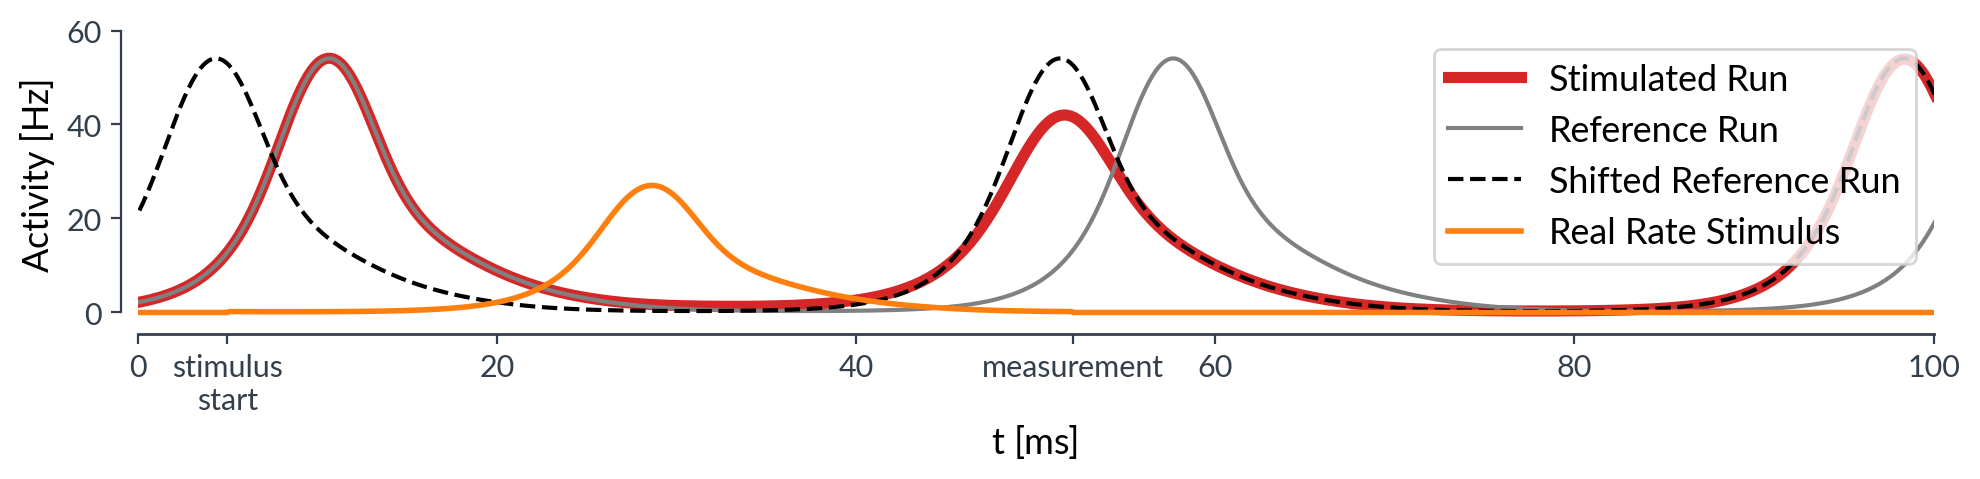

In [9]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

'''
Test the applicability of PRC as in "rapid decay"
'''

Ke_gl = 40
itype = "real"
stim_type = "step"
amplitude = 0.4
stim_len = 5
delay = 5


aln = np.load("data/aln_run_nice.npy", allow_pickle='TRUE').item()
aln_ref = np.load("data/aln_run_nice_ref.npy", allow_pickle='TRUE').item()
aln_s = np.load("data/aln_run_nice_stim.npy", allow_pickle='TRUE').item()

input_peak = delay + stim_len / 2

if input_peak < f_peak_ref:
    phase_t = prc.frperiod - (f_peak_ref - input_peak) # period - time to period end
elif input_peak < s_peak_ref:
    phase_t = prc.frperiod - (s_peak_ref - input_peak)
elif input_peak < t_peak_ref:
    phase_t = prc.frperiod - (t_peak_ref - input_peak)
else: 
    print("ERROR: stimulus delay > freerunning period")
    ic(delay, prc.frperiod)

# find peaks in stimulated runs and compare to freerunning reference
peaks, props = find_peaks(aln.rates_exc[0].T, prominence=3)
f_peak = peaks[0] * aln_s.params.dt  # in ms
s_peak = peaks[1] * aln_s.params.dt
t_peak = peaks[2] * aln_s.params.dt

# find phase shift to reference run by crosscorrelation 
# phase_shift in [-1, 1]

p_shift, dt_shift = phase_shift(aln_ref.rates_exc[0],
                          aln_s.rates_exc[0],
                          duration=6000, 
                          dt=aln.params.dt)
#ic(p_shift)
# evaluation point: 
eval_point = int((prc.frperiod + delay) / aln_s.params.dt)
#ic(self.frperiod + delay)
#ic(eval_point)
# calculate amplitude difference of stimulated and shifted reference run
ref_shifted = shift(aln_ref.rates_exc[0], int(dt_shift), cval=0)

amp_diff = aln_s.rates_exc[0][eval_point] - ref_shifted[eval_point]
#ic(aln.rates_exc[0][eval_point], ref_shifted[eval_point])
#ic(ref_shifted[eval_point])

fig, ax = plt.subplots(figsize=(10, 2.5), dpi=200)
#ax.set_title("amplitude diff: {0:.3f} Hz".format(amp_diff))
ic(amp_diff)
ax.plot(aln_s.t, aln_s.rates_exc[0].T, lw=4, c="tab:red", label="Stimulated Run")
ax.plot(aln_s.t, aln_ref.rates_exc[0].T, c="grey", label="Reference Run")
ax.plot(aln_s.t, ref_shifted.T, "--", color="black", label="Shifted Reference Run")
#ax.axvline(delay, color="grey")
#axs[0].axvspan(delay, delay+stim_len, facecolor='grey', alpha=0.4, label="stimulus")
#ax.axvline(prc.frperiod + delay, color="grey")
#ax.axvspan(prc.frperiod + delay, prc.frperiod + delay+stim_len, facecolor='grey', alpha=0.4)
#ic(len(aln.t), len(stimulus))
ax.plot(aln_s.t, stimulus[0]/2, c="tab:orange", lw=2, label="Real Rate Stimulus")

ax.set_xlim(0,100)
ax.set_ylim(-1, 60)
ax.set_xticks([0, delay, 20, 40, delay + prc.frperiod, 60, 80, 100])
ic(input_peak-f_peak_ref)
ax.set_xticklabels(labels=['0','stimulus\nstart', '20', '40', 'measurement', '60', '80', '100'] )
#axs[1].set_ylim(-1, 65)
#axs[1].legend(loc="upper right")

ax.tick_params(right=False, top=False)
#axs[1].tick_params(right=False, top=False, left=False)

ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)
#axs[1].spines["top"].set_visible(False), axs[1].spines["right"].set_visible(False)
#axs[1].spines["left"].set_visible(False)
#ax.spines["bottom"].set_bounds(low=0, high=100)
plt.draw()
lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')][1:]
ic(lab)
ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
ax.spines["left"].set_position(("outward", 6))
for line in ["bottom"]:
    ax.spines[line].set_linewidth(1)
    ax.spines[line].set_position(("outward",6))

ax.legend()
ax.set_xlabel("t [ms]")
ax.set_ylabel("Activity [Hz]")
#self.amp_diffs[delay] = amp_diff
fig.tight_layout()
#fig.savefig("Pics/Amp_Diff_method.pdf")